# 因使用plotly圖表，請至：https://nbviewer.jupyter.org/github/chloe8599/NTU-CSX-Project/blob/master/week10/news.ipynb 觀看

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import scipy as sp
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
def is_chinese(uchar):         
    if u'\u4e00' <= uchar<=u'\u9fff':
        return True
    else:
        return False
jieba.load_userdict("data/dict.txt")
with open('data/stop.txt', 'rt',encoding="utf-8") as txt:
    stopword = txt.read()
stopword = stopword.split("\n")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\chloe\AppData\Local\Temp\jieba.cache
Loading model cost 2.010 seconds.
Prefix dict has been built succesfully.


# 資料讀取&概覽

In [3]:
news1 = pd.read_csv("data/news1.csv",encoding="utf-8-sig")
news2 = pd.read_csv("data/news2.csv",encoding="utf-8-sig")
news3 = pd.read_csv("data/news3.csv",encoding="utf-8-sig")

In [4]:
news1.head()

,time,source,url,txt
0,2018.02.03,蘋果日報,https://tw.appledaily.com/headline/daily/20180...,日商「百尺竿頭」前年收購樂陞毀約，台北地院昨認定這場股海大騙局確由董事長許金龍主導，許還找國...
1,2018.09.13,蘋果日報,https://tw.appledaily.com/new/realtime/2018091...,訴後，又一敗訴案。等於金管會不到三個月，被兩個金融大老陸續提出行政救濟和行政訴訟後，連敗訴兩...
2,2018.04.07,蘋果日報,https://tw.appledaily.com/headline/daily/20180...,樂陞案刑事一審判決2月出爐，董座許金龍被法官痛斥「隻手遮天」，認定犯虛偽收購、炒股等7大罪，...
3,2018.04.06,蘋果日報,https://tw.appledaily.com/new/realtime/2018040...,樂陞案刑事一審判決2月出爐，董座許金龍被法官痛斥「隻手遮天」，認定犯非法私募、虛偽收購、炒股...
4,2018.06.03,蘋果日報,https://tw.appledaily.com/new/realtime/2018061...,樂陞案目前還在審理中，不過再次爆發樂陞重要投資人陳聰明違約交割，恐害元大證券代墊逾千萬元股款...


In [5]:
news2.head()

,time,source,url,txt
0,2017.04.09,蘋果日報,https://tw.appledaily.com/new/realtime/2017040...,富驛飯店慘賠扯兆豐洗錢案 兆豐駁斥 兆豐銀昨發布澄清稿，表示有媒體節目中，指稱「富驛飯店慘賠...
1,2017.05.22,蘋果日報,https://tw.appledaily.com/new/realtime/2017052...,只是不懂法規沒洗錢 兆豐洗錢案簽結 兆豐銀紐約分行去年疑涉洗錢遭美國重罰57億元，台北地...
2,2017.04.20,蘋果日報,https://tw.appledaily.com/new/realtime/2017042...,兆豐洗錢案 北檢首波查1.7萬筆交易暫無不法 兆豐銀紐約分行去年疑涉洗錢遭美國重罰57億...
3,2016.12.02,蘋果日報,https://tw.appledaily.com/new/realtime/2016120...,兆豐洗錢案 北檢啟動司法互助追真相 兆豐銀遭美國紐約州金融服務署（NYDFS）重罰台幣57...
4,2016.08.23,蘋果日報,https://tw.appledaily.com/new/realtime/2016082...,兆豐洗錢罰57億 公銀兵敗如山倒 2010至2014年間，兆豐銀行以紐約分行帳戶為跳板，...


In [6]:
news3.head()

,time,source,url,txt
0,2017.04.27,自由時報,http://news.ltn.com.tw/news/focus/paper/1097565,永豐金爆三案 李瑞倉︰下週完成金檢 \n 分享永豐金爆三案 李瑞倉︰下週完成金檢到Faceb...
1,2017.04.26,自由時報,http://news.ltn.com.tw/news/politics/breakingn...,黃國昌轟永豐金違法 要求金管會徹查 \n 分享黃國昌轟永豐金違法 要求金管會徹查到Faceb...
2,2017.04.21,自由時報,http://ec.ltn.com.tw/article/paper/1095946,李瑞倉 要找何壽川喝咖啡\n\n \n2017-04-21 06:00\n\n近期永豐金爭...
3,2017.06.27,自由時報,http://news.ltn.com.tw/news/focus/paper/1114026,邱正雄辭永豐金董事長 任期10天最短 \n 分享邱正雄辭永豐金董事長 任期10天最短到Fac...
4,2017.06.26,自由時報,http://ec.ltn.com.tw/article/breakingnews/2112579,震撼！邱正雄閃辭永豐金董座 任期至本週五\n\n \n2017-06-26 19:19\n...


In [7]:
#斷詞&tfidf
def keyword(df):
    corpus = []
    for t in list(df.txt):
        cut = list(jieba.cut(t))
        txt = []
        for word in cut:
            save = False
            if word in stopword:
                continue
            for w in word:
                if is_chinese(w) == False:
                    save = False
                    break
                else:
                    save = True
            if save == True:    
                txt.append(word)
        corpus.append(" ".join(txt))
    vectorizer = TfidfVectorizer(min_df=1, stop_words = stopword)
    tfidf = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    
    return tfidf,words
    

In [8]:
#Kmeans分群
LABEL_COLOR_MAP = {0:'tomato', 1: 'lime',2:"dodgerblue",3:"gold",4:"blueviolet",5:"darkcyan",6:"hotpink",7:"sienna",8:"darkgreen",9:"mediumpurple",10:"coral"}
def Newsclustering(n,df,tfidf):
    pca = PCA(n_components=2)
    x = pca.fit_transform(tfidf.toarray())
    kmeans = KMeans(n_clusters =n)
    X_clustered = kmeans.fit_predict(x)
    df["cluster"] = X_clustered
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]    
    trace = go.Scatter(
        x = x[:,0],
        y = x[:,1],
        mode = 'markers',
        text=[t+"<br>"+s for t,s in zip(df.time,df.source)],
        hoverinfo = 'text',
        marker={
            'size': 10,
            'opacity': 0.6,
            'color': label_color
        }
    )
    data = [trace]
    return py.iplot(data)

In [9]:
#長條圖
def newsbar(df):
    cluster_df = []
    for n in sorted(df.cluster.unique(),reverse=False):
        cluster_df.append(df[df.cluster==n].source.value_counts(ascending=True).to_frame())
    cluster_merge = pd.concat([cdf for cdf in cluster_df],axis=1,sort=False).fillna(0)
    cluster_merge.columns=["cluster"+str(n) for n in sorted(df.cluster.unique(),reverse=False)]


    data=[]
    n=0
    for col in cluster_merge:    
        t = go.Bar(
        y=cluster_merge.index,
        x=cluster_merge[col],
        name=col,
        orientation = 'h',
        text=[str(int(round(p,2)*100))+"%" for p in cluster_merge[col]/cluster_merge.sum(axis=1)],
        opacity=0.8, 
        marker = dict(
            color = LABEL_COLOR_MAP[n],
            line = dict(
                color = LABEL_COLOR_MAP[n],
                width = 3)
            )
        )
        data.append(t)
        n+=1
    layout = go.Layout(
        barmode='stack',
        title="新聞分群來源",
        titlefont= {
        "size": 36,
        "family":'Microsoft JhengHei,Courier New, monospace',

      },
         xaxis=dict(
            title='數量',
            titlefont=dict(
                family='Microsoft JhengHei,Courier New, monospace',
                size=18,
                color='black'
            )
        ),
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig)

In [10]:
#文字雲
def wordclound(df,tfidf,words):
    for clu in sorted(df.cluster.unique()):
        cluster={}
        for i in df[df.cluster==clu].index:
            for j in range(len(words)):
                if tfidf[i,j] > 0.15:
                    if words[j] in cluster:
                        cluster[words[j]] += tfidf[i,j]
                    else:
                        cluster[words[j]] = tfidf[i,j]
        wordcloud = WordCloud(background_color="white",width=2000, height=1000, margin=2,font_path = "msjh.ttc")
        wordcloud.fit_words(cluster)
        plt.rcParams["font.sans-serif"]=["SimHei"]
        fig = plt.figure(figsize=(12,10))
        plt.title("cluster"+str(clu),fontsize=30)
        plt.grid(False)
        plt.imshow(wordcloud)
       

# 樂陞案

In [11]:
N1 = keyword(news1)
Newsclustering(2,news1,N1[0])

In [12]:
newsbar(news1)

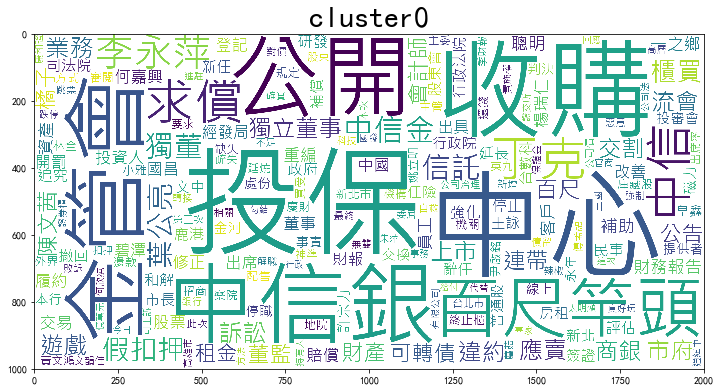

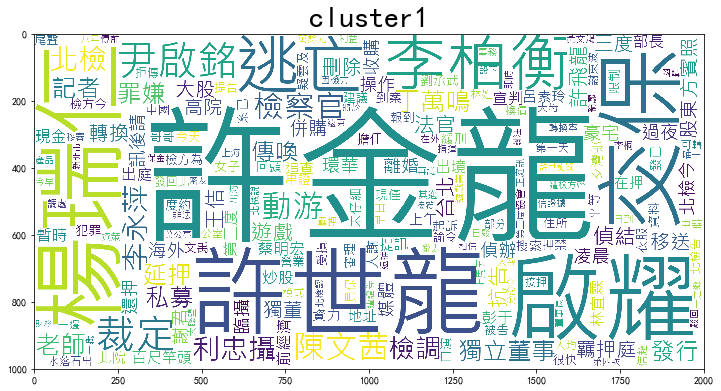

In [13]:
wordclound(news1,N1[0],N1[1])

# 兆豐洗錢案

In [14]:
N2 = keyword(news2)
Newsclustering(2,news2,N2[0])

In [15]:
newsbar(news2)

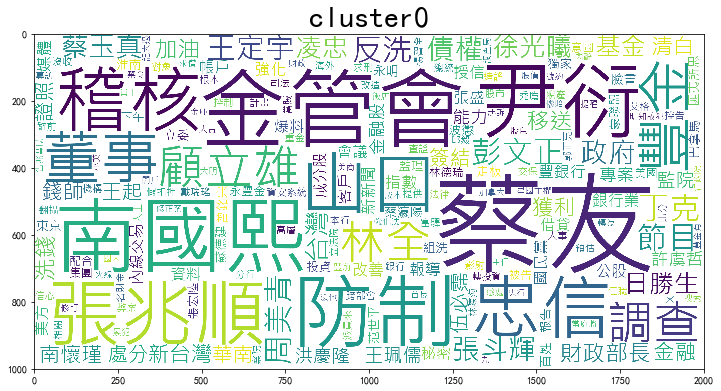

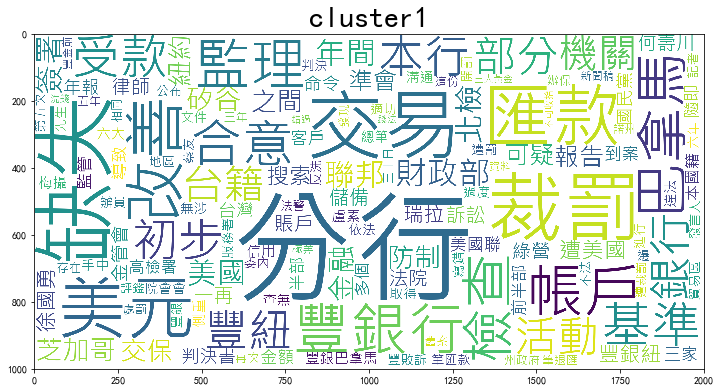

In [16]:
wordclound(news2,N2[0],N2[1])

# 永豐金超貸案

In [17]:
N3 = keyword(news3)
Newsclustering(2,news3,N3[0])

In [18]:
newsbar(news3)

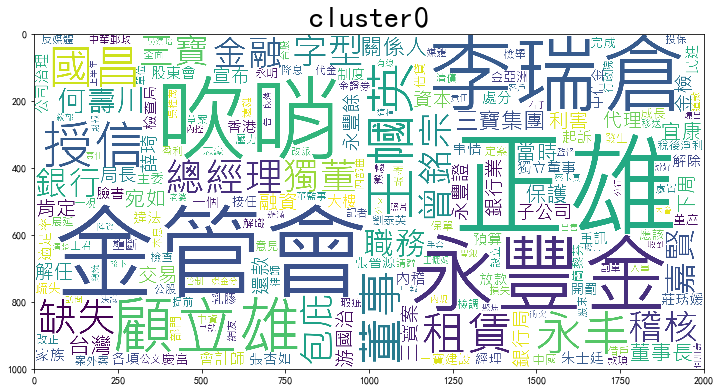

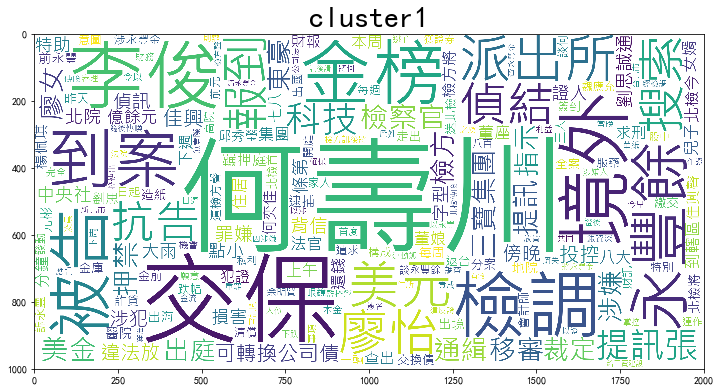

In [19]:
wordclound(news3,N3[0],N3[1])